# ATCS

This is the demo file. First allows for custom checking of entailment.

Second part shows the performans of various sentence embedding models.

In [1]:
import os
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import argparse
from collections import Counter
from torchtext.data import get_tokenizer
from torchtext.vocab import Vocab
from IPython.display import display
import matplotlib.pyplot as plt
from pl_model import SentenceEmbeddings
from pytorch_lightning import seed_everything
seed_everything(42)

Global seed set to 42


42

## Demo

We first define a few functions in which we transform a normal sentence to their word embeddings.
Similairy we create a small function to load a model with optionnaly (but strongly recommanded) a model checkpoint.
Lastly we create a function which has combines the two, and predict the entailment given a model, a primse and a hypoythesis.

In [2]:
def create_data(premise, hypothesis):
    tokenizer = get_tokenizer("spacy")
    sentences = [premise, hypothesis]
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenizer(sentence))
    TEXT = Vocab(counter, specials=('<unk>', '<BOS>', '<EOS>', '<pad>'), vectors='glove.840B.300d')
    funct = lambda x: torch.tensor([TEXT['<BOS>']] + [TEXT[token] for token in tokenizer(x)] + [TEXT['<EOS>']])
    return funct(premise), funct(hypothesis), TEXT.vectors

def load_model(model_type, checkpoint_path=None):
    parser = argparse.ArgumentParser()
    parser = SentenceEmbeddings.add_model_specific_args(parser)
    args = parser.parse_known_args()
    model_params = vars(args[0])
    model_params['model'] = model_type
    model = SentenceEmbeddings(torch.rand(1, 300), **model_params)
    if checkpoint_path:
        state_dict = torch.load(checkpoint_path, map_location=model.device)
        if 'state_dict' in state_dict.keys():
            state_dict = state_dict['state_dict']
        try:
            del state_dict['embedding.weight']
        except Exception:
            pass
        model.load_state_dict(state_dict, strict=False)
    model.cuda()
    model.eval()
    return model
    
def predict(model, premise, hypothesis):
    premise, hypothesis, vectors = create_data(premise, hypothesis)
    premise = premise.unsqueeze(0).to(model.device)
    hypothesis = hypothesis.unsqueeze(0).to(model.device)
    vectors = vectors.to(model.device)
    model.reset_embedding(vectors)
    with torch.no_grad():
        pred = F.softmax(model((premise, hypothesis)), dim=-1)
    results = torch.argmax(pred, dim=-1).cpu().item()
    pred = pred.cpu().numpy()
    convert = {'Entailment' :'Entailment', 1:'Neutral', 2:'Contradiction'}
    del premise
    del hypothesis
    del vectors
    return convert[results], {'Entailment':np.round(pred[0, 0]*100, 2), 'Neutral':np.round(pred[0, 1]*100, 2), 'Contradiction':np.round(pred[0, 2]*100, 2)}

In [3]:
# Choose which model to load. Pre-trained models can be found on github. See the readme for more details.
# 'words'  'lstm'  'bilstm'  'bilstm_max'
# 'checkpoint_words.pth'  'checkpoint_lstm.pth'  'checkpoint_bilstm.pth'  'checkpoint_bilstm_max.pth'
model = load_model('words', checkpoint_path='checkpoint_words.pth')

In [9]:
# Formulate your own premise and hypothesis and the model will predict the inference.
premise = 'A smiling costumed woman is holding an umbrella.'
hypothesis = 'A happy woman in a fairy costume holds an umbrella.'

result = predict(model, premise, hypothesis)
print(result[0])
print(result[1])

Neutral
{'Entailment': 5.68, 'Neutral': 52.81, 'Contradiction': 41.51}


## Results
Below we put the results for the various NLP tasks into a pandas dataframe for easy comparison.

In [10]:
models = ["words", "lstm", "bilstm", "bilstm_max"]
standard_results = set(['CR', 'MR', 'MPQA', 'SUBJ', 'SST2', 'TREC', 'MRPC',
                        'SICKEntailment', 'SICKRelatedness', 'STS14'])
extra_results = set(['SST5', 'SNLI', 'STSBenchmark',
                        'STS12', 'STS13', 'STS15', 'STS16',
                        'Length', 'WordContent', 'Depth', 'TopConstituents','BigramShift', 'Tense',
                        'SubjNumber', 'ObjNumber', 'OddManOut', 'CoordinationInversion'])

def create_results(models, metrics, mode='devacc', avg=True):
    assert mode=='devacc' or mode=='acc'
    res = {}
    for model in models:
        model_results = torch.load(f"results_{model}.pt")
        del_keys = set(model_results.keys()).difference(metrics)
        for i in del_keys:
            del model_results[i]
        res[model] = model_results
       
    for model in models:
        res[model]['micro'] = []
        res[model]['macro'] = []
        for metric in metrics:
            res_dict = res[model][metric]
            if mode in res_dict.keys():
                res[model]['macro'].append(res[model][metric][mode])
                if 'dev' in mode:
                    res[model]['micro'].append((res[model][metric][mode], res[model][metric]['ndev']))
                else:
                    res[model]['micro'].append((res[model][metric][mode], res[model][metric]['ntest']))
                res[model][metric] = res[model][metric][mode]
                
            else:
                if 'all' in res[model][metric].keys():
                    res[model][metric] = f"{np.round(res[model][metric]['all']['pearson']['mean'], 2)}/{np.round(res[model][metric]['all']['spearman']['mean'], 2)}"
                else:
                    
                    if 'dev' in mode:
                        res[model][metric] = np.round(res[model][metric]['devpearson'], 3)
                    else:
                        res[model][metric] = np.round(res[model][metric]['pearson'], 3)
        if avg:
            res[model]['macro'] = np.round(np.average(res[model]['macro']), 2)
            res[model]['micro'] = np.round(np.average(np.array([i[0] for i in res[model]['micro']]), weights=np.array([i[1] for i in res[model]['micro']])), 2)
        else:
            del res[model]['macro']
            del res[model]['micro']
    return res

,CR,MR,MPQA,SUBJ,SST2,TREC,MRPC,SICKEntailment,SICKRelatedness,STS14,micro,macro
words,79.94,78.00,88.22,91.75,79.01,74.27,72.79,70.4,0.696,0.55/0.56,82.54,79.30
lstm,81.24,77.81,88.38,86.04,70.76,57.70,71.66,79.4,0.762,0.49/0.47,79.27,76.62
bilstm,84.01,80.41,89.19,90.93,77.29,82.01,71.91,84.8,0.840,0.53/0.52,84.45,82.57
bilstm_max,83.98,79.92,89.63,92.82,81.54,84.21,74.93,86.2,0.892,0.69/0.67,85.47,84.15


,SST5,SNLI,STSBenchmark,STS12,STS13,STS15,STS16,Length,WordContent,Depth,TopConstituents,BigramShift,Tense,SubjNumber,ObjNumber,OddManOut,CoordinationInversion
words,44.69,65.87,0.670,0.52/0.53,0.5/0.51,0.56/0.59,0.51/0.58,60.26,79.53,33.55,62.87,51.88,85.64,79.92,76.12,50.83,53.74
lstm,31.61,72.78,0.654,0.42/0.42,0.41/0.42,0.48/0.49,0.48/0.5,61.82,26.45,35.61,40.62,64.32,81.38,72.10,73.32,58.41,67.48
bilstm,39.33,77.25,0.730,0.56/0.55,0.49/0.5,0.57/0.59,0.56/0.59,73.68,45.44,40.74,75.55,64.77,87.08,86.06,79.24,57.85,71.72
bilstm_max,44.69,84.39,0.803,0.63/0.62,0.57/0.58,0.7/0.72,0.71/0.73,75.23,89.24,38.01,76.34,59.61,88.06,84.44,79.48,53.68,66.71


<AxesSubplot:>

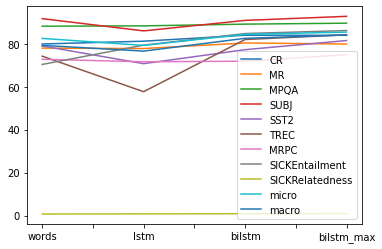

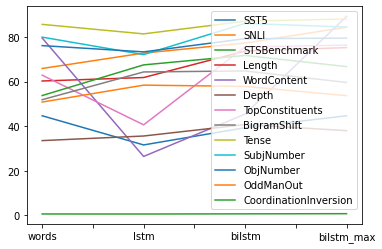

In [11]:
devacc = pd.DataFrame.from_dict(create_results(models, standard_results), orient='index')
devacc_extra = pd.DataFrame.from_dict(create_results(models, extra_results, avg=False), orient='index')
display(devacc)
display(devacc_extra)
devacc.plot(rot=0, use_index=True)
devacc_extra.plot(rot=0, use_index=True)

,CR,MR,MPQA,SUBJ,SST2,TREC,MRPC,SICKEntailment,SICKRelatedness,STS14,micro,macro
words,78.49,77.47,87.86,91.45,81.05,81.6,71.77,75.22,0.763,0.55/0.56,82.96,80.61
lstm,79.52,77.12,87.93,85.35,68.04,47.4,69.28,80.70,0.793,0.49/0.47,81.18,74.42
bilstm,83.05,79.74,88.59,90.44,79.02,85.2,71.71,84.55,0.857,0.53/0.52,84.84,82.79
bilstm_max,82.73,79.03,88.91,92.28,83.75,89.8,74.72,85.95,0.888,0.69/0.67,85.66,84.65


,SST5,SNLI,STSBenchmark,STS12,STS13,STS15,STS16,Length,WordContent,Depth,TopConstituents,BigramShift,Tense,SubjNumber,ObjNumber,OddManOut,CoordinationInversion
words,44.25,64.71,0.556,0.52/0.53,0.5/0.51,0.56/0.59,0.51/0.58,59.70,79.15,33.35,62.45,51.01,84.15,78.51,76.58,51.57,53.89
lstm,35.84,71.14,0.607,0.42/0.42,0.41/0.42,0.48/0.49,0.48/0.5,61.35,25.34,35.93,41.63,61.32,81.70,72.96,74.00,61.83,65.77
bilstm,40.72,75.86,0.704,0.56/0.55,0.49/0.5,0.57/0.59,0.56/0.59,73.69,44.87,41.44,76.38,62.42,86.12,86.37,79.88,60.85,70.62
bilstm_max,45.52,83.95,0.770,0.63/0.62,0.57/0.58,0.7/0.72,0.71/0.73,76.25,89.09,38.30,76.88,59.20,86.67,83.96,79.96,53.86,66.71


<AxesSubplot:>

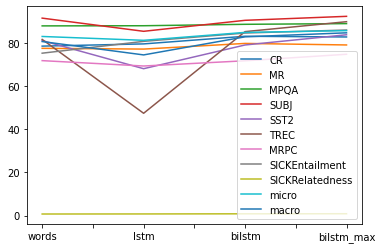

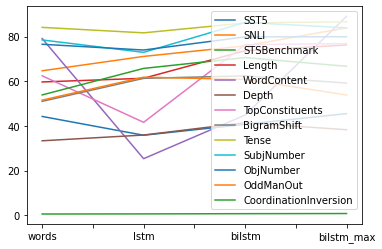

In [12]:
acc = pd.DataFrame.from_dict(create_results(models, standard_results, mode='acc'), orient='index')
acc_extra = pd.DataFrame.from_dict(create_results(models, extra_results, mode='acc', avg=False), orient='index')
display(acc)
display(acc_extra)
acc.plot(rot=0, use_index=True)
acc_extra.plot(rot=0, use_index=True)